In [9]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset




In [2]:
# Read in connectomes
test_connectome = pd.read_csv('/Users/rubyc/Desktop/Datathon/WIDS_Datathon2025_Team/Archive/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
train_connectome = pd.read_csv('/Users/rubyc/Desktop/Datathon/WIDS_Datathon2025_Team/Archive/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')

In [3]:
# Read in solutions 
solutions = pd.read_excel('/Users/rubyc/Desktop/Datathon/WIDS_Datathon2025_Team/Archive/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx')


In [4]:
solutions.head()

participant_id  ADHD_Outcome  Sex_F
0   UmrK0vMLopoR             1      1
1   CPaeQkhcjg7d             1      0
2   Nb4EetVPm3gs             1      0
3   p4vPhVu91o4b             1      1
4   M09PXs7arQ5E             1      1

# Denoising Autoencoder DAE

In [4]:
# Merge Connectome
merged_connectome = pd.concat([train_connectome, test_connectome], ignore_index=True)

Hypertuning parameters to consider
- Latent dimension 
- Learning rate
- Beta coefficient
- Network architecture
- Attention mechanism 

In [6]:
merged_connectome.shape

(1517, 19901)

In [7]:
test_connectome

participant_id  0throw_1thcolumn  0throw_2thcolumn  0throw_3thcolumn  \
0     Cfwaf5FX7jWK          0.548480          0.713607          0.557319   
1     vhGrzmvA3Hjq          0.427740          0.363022          0.402862   
2     ULliyEXjy4OV          0.139572          0.390106         -0.087041   
3     LZfeAb1xMtql          0.133561          0.778326          0.416355   
4     EnFOUv0YK1RG          0.126699          0.575446          0.509422   
..             ...               ...               ...               ...   
299   UadZfjdEg7eG          0.029721          0.596742          0.361898   
300   IUEHiLmQAqCi          0.025985          0.347840          0.304804   
301   cRySmCadYFRO          0.105385          0.443624         -0.019777   
302   E3MvDUtJadc5          0.345641          0.758986          0.748153   
303   dQJXfyRazknD          0.574983          0.497672          0.206867   

     0throw_4thcolumn  0throw_5thcolumn  0throw_6thcolumn  0throw_7thcolumn  \
0            0.524369          0.693364          0.770032          0.724406   
1            0.363003          0.534558          0.345347          0.409471   
2            0.196852          0.088148          0.023843          0.381782   
3            0.471840          0.568460          0.633660          0.501113   
4            0.363193          0.427544          0.449924          0.451796   
..                ...               ...               ...               ...   
299          0.292066          0.553130          0.476284          0.543970   
300          0.463090          0.305321          0.267397          0.468712   
301          0.435582          0.376492          0.619322          0.430177   
302          0.442141          0.571924          0.485011          0.530513   
303          0.443488          0.283010          0.502524          0.350450   

     0throw_8thcolumn  0throw_9thcolumn  ...  195throw_196thcolumn  \
0            0.390118          0.547912  ...              0.080423   
1            0.303328          0.402515  ...              0.198009   
2            0.068979          0.377488  ...              0.051319   
3            0.345461          0.467943  ...              0.046183   
4            0.223927          0.298248  ...              0.315734   
..                ...               ...  ...                   ...   
299          0.372932          0.595183  ...              0.021524   
300          0.155677          0.298155  ...              0.044974   
301          0.567600          0.399820  ...              0.145582   
302          0.137672          0.467144  ...              0.036169   
303          0.113193          0.239293  ...              0.194971   

     195throw_197thcolumn  195throw_198thcolumn  195throw_199thcolumn  \
0               -0.054581             -0.088163             -0.028574   
1               -0.000724              0.083122              0.033043   
2                0.023630             -0.056819              0.117396   
3               -0.238962              0.121868             -0.260970   
4                0.002234              0.290791              0.344149   
..                    ...                   ...                   ...   
299             -0.162832              0.105546              0.028975   
300             -0.078047             -0.118271              0.035741   
301              0.004455              0.134574             -0.152951   
302             -0.345563             -0.165280             -0.347035   
303              0.144088              0.007635              0.126100   

     196throw_197thcolumn  196throw_198thcolumn  196throw_199thcolumn  \
0                0.444847              0.350149             -0.012601   
1                0.687497              0.306229              0.717485   
2                0.576086              0.517831              0.527044   
3                0.646818              0.594902              0.608156   
4                0.480214              0.539824            

# Check GPU 

In [5]:
print(tf.config.list_physical_devices('GPU'))

device = 'mps' if torch.backends.mps.is_available() else 'cpu'



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Denoising Autoencoder

Training the DAE using the training data only

Construct a graph for each patient

Layer options

- Graph convolution network GCN layers

- Graph attention network

- GraphSAGE

### Graph Construct

In [9]:
def create_graph_construct(df, num_regions=200):
    # List to store graph constructs for all participants
    graph_list = []

    # Loop through each row
    for _, row in df.iterrows():
        participant_row = row.values  # Convert row to array
        
        # Empty 200x200 adjacency matrix
        adj_matrix = np.zeros((num_regions, num_regions))

        
        idx = 1  # Skip participant_id
        for i in range(num_regions):
            for j in range(i + 1, num_regions):  
                adj_matrix[i, j] = participant_row[idx] # Upper triangle
                adj_matrix[j, i] = participant_row[idx]  # Lower
                idx += 1

        # Create edge list and weights
        edges = []
        edge_weights = []

        for i in range(num_regions):
            for j in range(i + 1, num_regions):    
            #for j in range(num_regions):
                weight = adj_matrix[i, j]
                if i != j:  # Exclude where i == j
                    edges.append([i, j])
                    edge_weights.append(weight)

        # Convert to torch tensors
        edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)  # Shape: (2, num_edges)
        edge_attr = torch.tensor(edge_weights, dtype=torch.float)  # Shape: (num_edges,)
        x = torch.eye(num_regions, dtype=torch.float)

        # Create PyTorch Geometric Data object
        x = torch.eye(num_regions, dtype=torch.float)  # Shape: (200, 200)
        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, num_nodes=num_regions)

        # Add to list
        graph_list.append(graph_data)

    return graph_list

In [10]:
# Implement 
train_graph_list = create_graph_construct(train_connectome)

In [11]:
# Print stats
sample_graph = train_graph_list[0]
print(sample_graph)

Data(x=[200, 200], edge_index=[2, 19900], edge_attr=[19900], num_nodes=200)


In [12]:
# A and B is the same as B and A
def is_undirected(graph):
    edge_index = graph.edge_index.numpy().T  # Shape: (num_edges, 2)
    edge_set = set(map(tuple, edge_index))

    for u, v in edge_set:
        if (v, u) not in edge_set:
            return False
    return True

# Check one graph
print(is_undirected(train_graph_list[0]))

# check all graphs
all_undirected = all(is_undirected(g) for g in train_graph_list)
print(all_undirected)

False
False


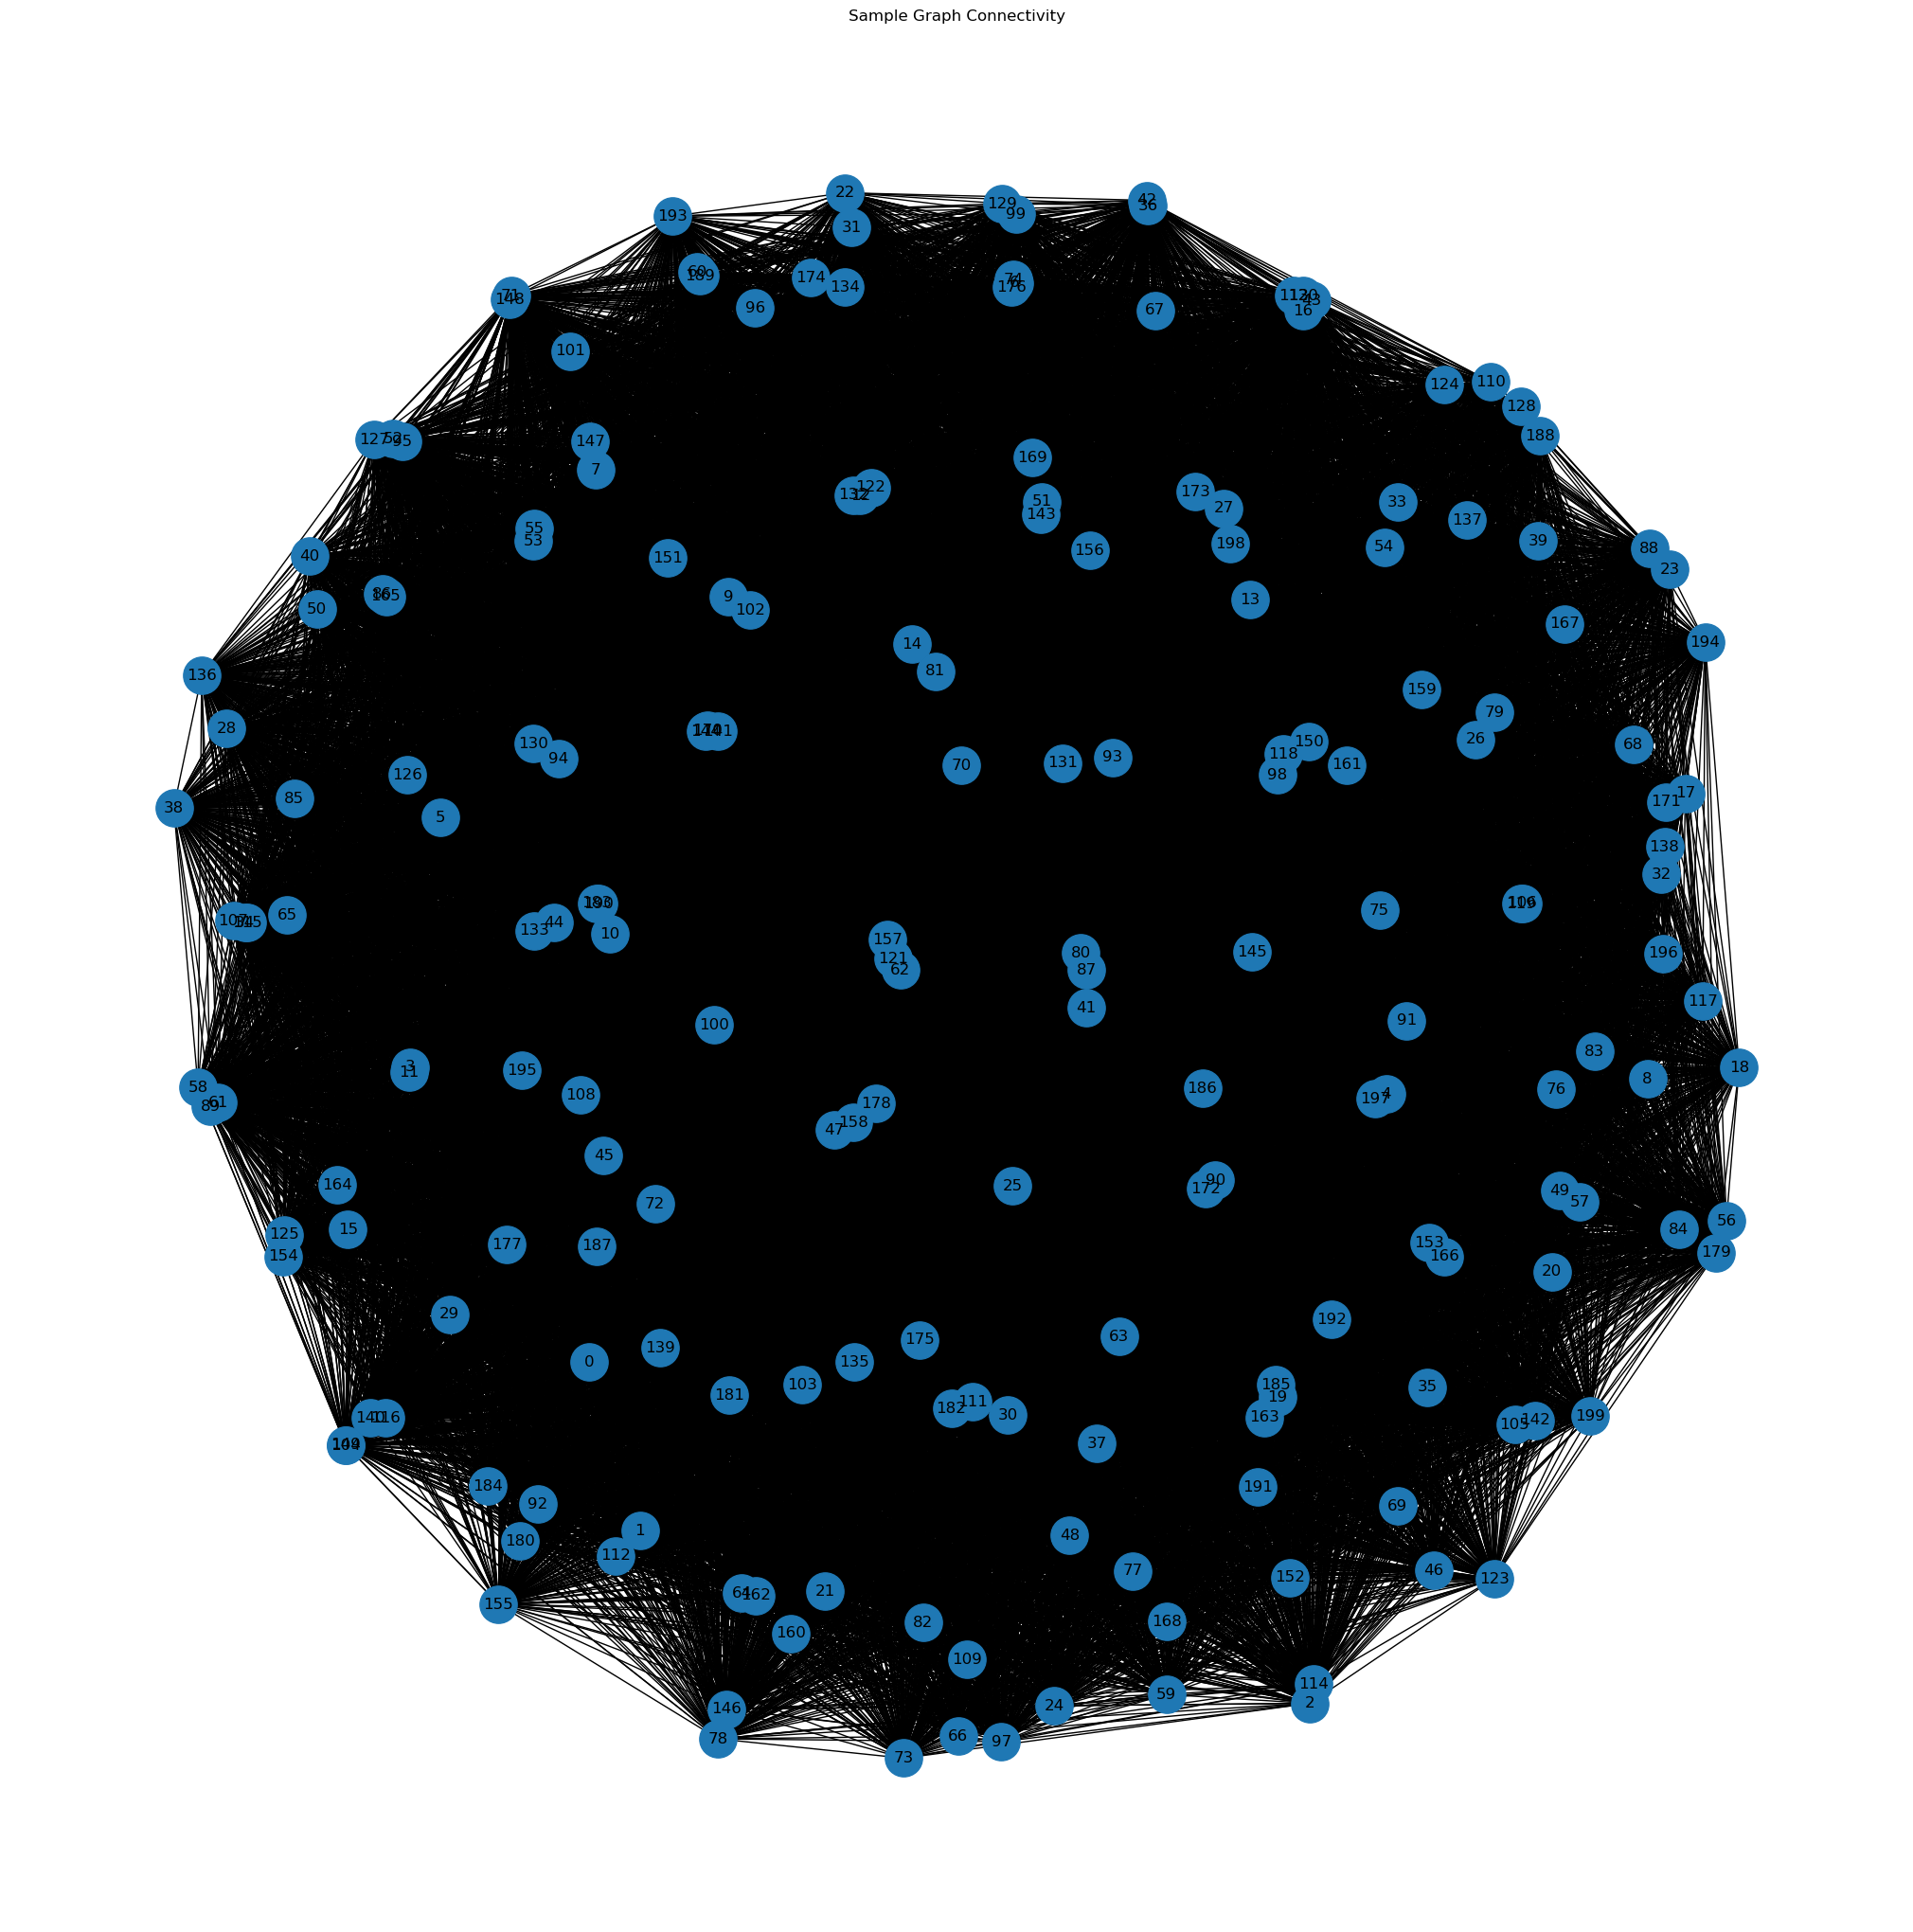

In [13]:
# Convert to NetworkX (no weights)
nx_graph = to_networkx(sample_graph, to_undirected=True)

# Draw the graph
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, with_labels=True, node_size=800, font_size=12)
plt.title("Sample Graph Connectivity")
plt.show()

plt.show()



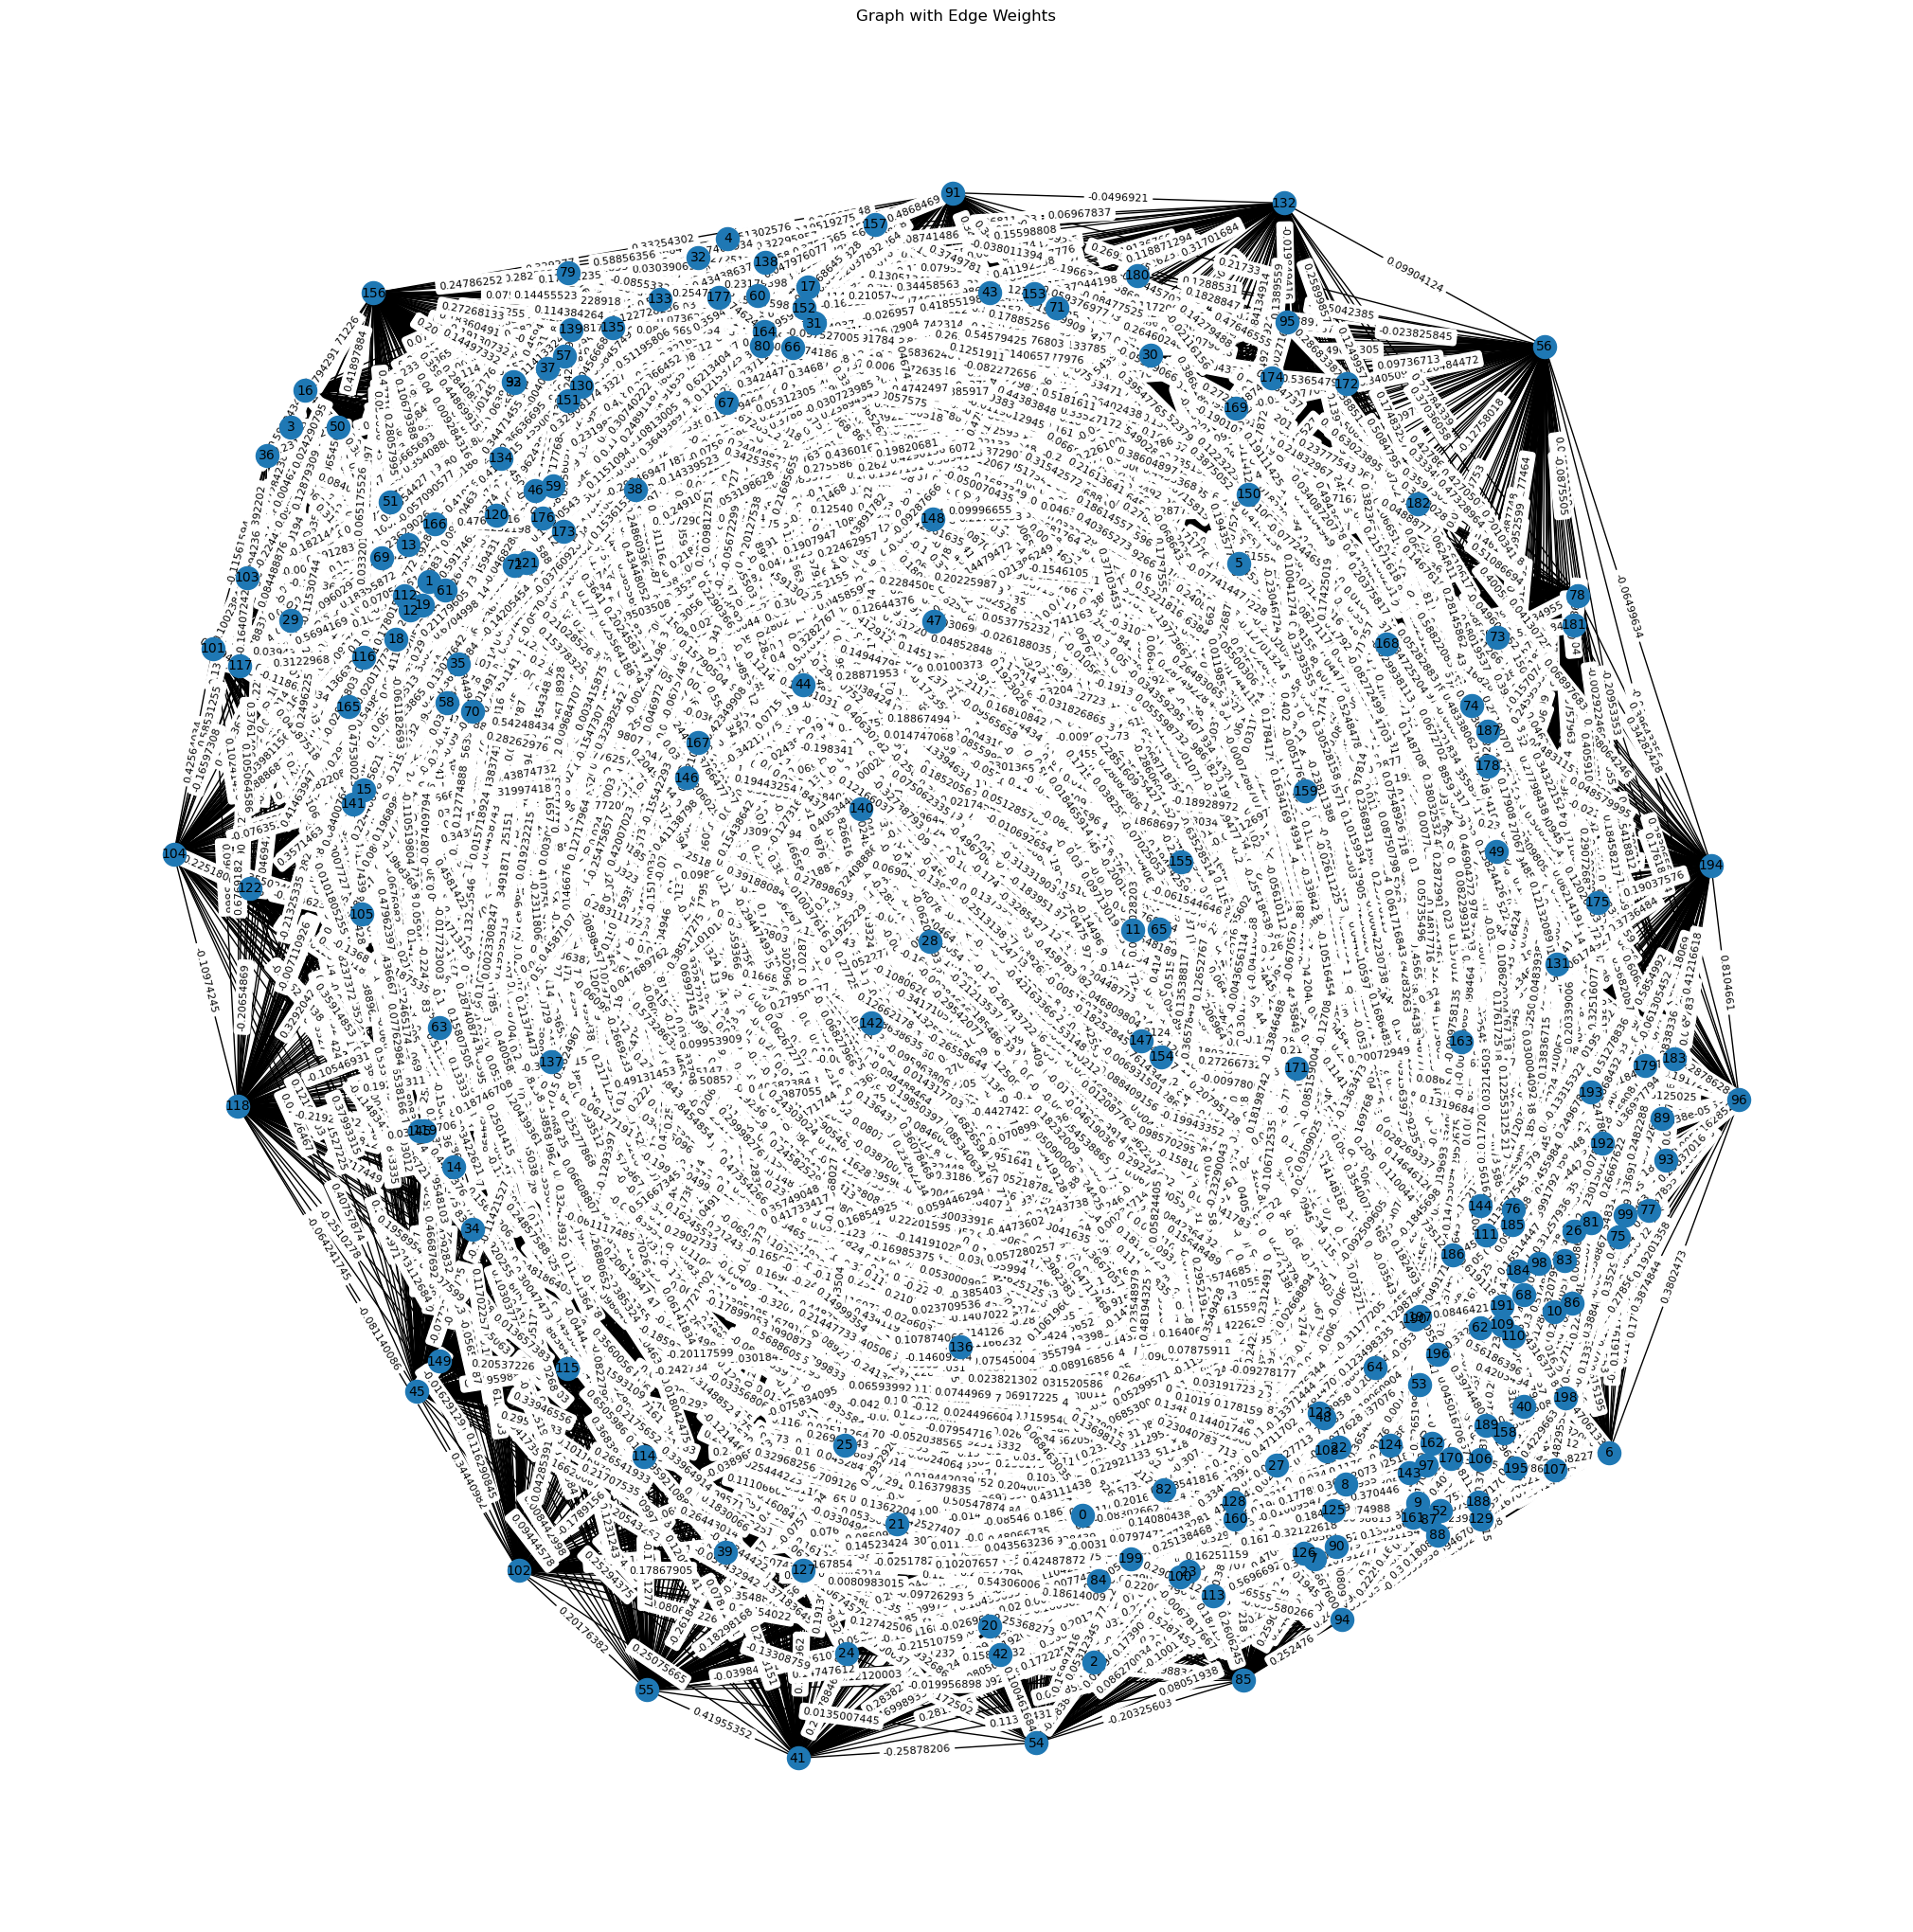

In [14]:
# Add edge weights manually from edge_attr
edge_weights = sample_graph.edge_attr.numpy()
edges = sample_graph.edge_index.numpy().T

# Convert to NetworkX (with weights)
G = nx.Graph()
for (i, j), w in zip(edges, edge_weights):
    G.add_edge(i, j, weight=w)

plt.figure(figsize=(20, 20))
# Draw with edge labels (weights)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=300, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Graph with Edge Weights")
plt.show()


In [15]:
num_edges = []
mean_weights = []
max_weights = []
min_weights = []

for graph in train_graph_list:
    num_edges.append(graph.edge_index.shape[1])
    mean_weights.append(graph.edge_attr.mean().item())
    max_weights.append(graph.edge_attr.max().item())
    min_weights.append(graph.edge_attr.min().item())

print("Avg number of edges:", np.mean(num_edges))
print("Mean weight:", np.mean(mean_weights))
print("Max weight:", np.max(max_weights))
print("Min weight:", np.min(min_weights))

Avg number of edges: 19900.0
Mean weight: 0.022694537696821702
Max weight: 0.9590231776237488
Min weight: -0.875395655632019


### DAE construct

Architecture
- Encoder
- Decoder
- Noise mechanism 
- Loss Function

Components
- GCN layer
- Input Feature - x = torch.eye(200) 
- Output target - Node features (x)
    - DAE reconstructs enhanced node features
    - GNN compatible
    - captures both local structure and noise-robust patterns
    - compact

Noise mechnaisms:
- masking edge weights
- adding Gaussian noise to edge weights
- Perturb X

In [24]:
class GraphDAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout=0.2):

        super(GraphDAE, self).__init__()
        self.dropout = dropout

        # Encoder layer: learns node embeddings, compressed node into latent_dim
        self.conv1 = GCNConv(input_dim,hidden_dim)
        self.conv_intermediate = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)


        # Decoder layer: Fully connected layers to predict edge weights between node pairs
        self.fullc1 = nn.Linear(latent_dim * 2, hidden_dim) 
        self.fullc2 = nn.Linear(hidden_dim, 1)

        # Activation functions
        self.relu = nn.ReLU() # non-linearity
        self.sigmoid = nn.Sigmoid() # weights are [0,1]

    def add_noise(self, edge_index, edge_attr, noise_factor=0.05):
        
        mask = torch.rand(edge_attr.size()) > self.dropout # Randomly drop edge weights
        noisy_edge_attr = edge_attr.clone() # Clone to not modify original

        # Using Gaussian noise to non-dropped edges * by noise factor
        noisy_edge_attr[mask] += torch.randn(sum(mask)).to(edge_attr.device) * noise_factor # randomly generates a value and saves it to same device original tensor is stored
        return edge_index, noisy_edge_attr
    
    # Encoder
    def encode(self, x, edge_index, edge_attr):

        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv_intermediate(x, edge_index)) # Encode the graph to latent node embeddings using GCN layers
        x = self.conv2(x, edge_index)
        return x
    
    # Decoder
    def decode(self, z, edge_index):

        # concatenate embeddings z[i] and z[j] represents each node
        edge_features = torch.cat([z[edge_index[0]], z[edge_index[1]]], dim=-1)

        x = self.relu(self.fullc1(edge_features))

        x = self.fullc2(x).squeeze()
        return self.sigmoid(x)
    
    # Combines all steps: noise, encode, and decode
    # Returns reconstructed edge weights nad z a tensor object of latent node embeddings
    def forward(self, data):

        x,edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # Normalize to [0,1]
        edge_attr = (edge_attr - edge_attr.min()) / (edge_attr.max() - edge_attr.min() + 1e-6)
        # Add noise 
        noisy_edge_index, noisy_edge_attr = self.add_noise(edge_index, edge_attr)
        # Encode noisy graph to latent embeddings
        z = self.encode(x, noisy_edge_index, noisy_edge_attr)
        # Decode to reconstruct clean edge weights
        recon_edge_attr = self.decode(z, edge_index)

        return recon_edge_attr, z


In [ ]:
# Train the decoder

# Parameters
input_dim = 200 # number of nodes
hidden_dim = 128 # number of neurons in nn
latent_dim = 64 # latent embedding size per ned
batch_size = 32
epochs = 50

model = GraphDAE(input_dim, hidden_dim, latent_dim).to(device) # move mode to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss() # metric

graph_list = create_graph_construct(train_connectome, num_regions=200)
loader = DataLoader(graph_list, batch_size=batch_size, shuffle=True) # Organizes graph_list into batches, since our graph_list is a list of Data objects, training on one at a time is slow
# and all at once is too much

# Train loop for batches
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward
        recon_edge_attr, z = model(batch)

        loss = criterion(recon_edge_attr, batch.edge_attr)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
avg_loss = total_loss / len(loader)

print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader)}")
print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    # Early stopping if loss plateaus
if avg_loss < 0.005:  # Target threshold
    print("Stopping early")
    break



In [ ]:
# torch.save(model.state_dict(), "models/dae_final.pth")

# Non Graph Autoencoder


In [15]:
class NonGraphDAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout=0.2):
        
        super(NonGraphDAE, self).__init__()
        self.dropout = dropout

        # Encoder layer: learns node embeddings, compressed node into latent_dim
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layer: Fully connected layers to predict edge weights between node pairs
        self.dec1 = nn.Linear(latent_dim, hidden_dim) 
        self.dec2 = nn.Linear(hidden_dim, input_dim)

        # Activation functions
        self.relu = nn.ReLU() # non-linearity

    def add_noise(self, x, noise_factor=0.05):
        
        noisy_x = x.clone() # Clone to not modify original
        mask = torch.rand(x.size(), device = x.device) > self.dropout # Randomly drop edge weights
        noise = torch.randn_like(x) * noise_factor
        noisy_x[mask] += noise[mask]

        return noisy_x
    
    # Encoder
    def encode(self, x):

        x = self.relu(self.enc1(x))# Encode the graph to latent node embeddings using GCN layers
        x = self.enc2(x)
        return x
    
    # Decoder
    def decode(self, z):

        x = self.relu(self.dec1(z))
        x = self.dec2(x)
        return x
    
    # Combines all steps: noise, encode, and decode
    # Returns reconstructed edge weights nad z a tensor object of latent node embeddings
    def forward(self, x):

        # Add noise 
        noisy_x = self.add_noise(x)
        # Encode noisy graph to latent embeddings
        z = self.encode(noisy_x)
        # Decode to reconstruct clean edge weights
        recon_x = self.decode(z)

        return recon_x, z

In [16]:
# Preprocess
features = train_connectome.drop(columns=['participant_id']).values
x = torch.tensor(features, dtype=torch.float32)
print("x shape:", x.shape) 

x shape: torch.Size([1213, 19900])


In [ ]:
# Model parameters
input_dim = x.shape[1]  # 19900
hidden_dim = 512
latent_dim = 128
dropout = 0.3
noise_factor = 0.1
batch_size = 32

# Initialize model
model = NonGraphDAE(input_dim, hidden_dim, latent_dim, dropout)

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
model = model.to(device)

# DataLoader
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training loop
num_epochs = 150
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        recon_x, z = model(batch_x)
        loss = criterion(recon_x, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.6f}')


Epoch [1/150], Avg Loss: 0.041083
Epoch [2/150], Avg Loss: 0.033235
Epoch [3/150], Avg Loss: 0.031216
Epoch [4/150], Avg Loss: 0.030062
Epoch [5/150], Avg Loss: 0.029334
Epoch [6/150], Avg Loss: 0.028820
Epoch [7/150], Avg Loss: 0.028342
Epoch [8/150], Avg Loss: 0.028031


# Non-Graph Autoencoder

In [13]:
class NonGraphDAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout=0.2):
        
        super(NonGraphDAE, self).__init__()
        self.dropout = dropout

        # Encoder layer: learns node embeddings, compressed node into latent_dim
        self.enc1 = nn.Linear(input_dim, hidden_dim)
        self.enc2 = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layer: Fully connected layers to predict edge weights between node pairs
        self.dec1 = nn.Linear(latent_dim, hidden_dim) 
        self.dec2 = nn.Linear(hidden_dim, input_dim)

        # Activation functions
        self.relu = nn.ReLU() # non-linearity
    
    # Encoder
    def encode(self, x):

        x = self.relu(self.enc1(x))# Encode the graph to latent node embeddings using GCN layers
        x = self.enc2(x)
        return x
    
    # Decoder
    def decode(self, z):

        x = self.relu(self.dec1(z))
        x = self.dec2(x)
        return x
    
    # Combines all steps: noise, encode, and decode
    # Returns reconstructed edge weights nad z a tensor object of latent node embeddings
    def forward(self, x):

        # Encode noisy graph to latent embeddings
        z = self.encode(x)
        # Decode to reconstruct clean edge weights
        recon_x = self.decode(z)

        return recon_x, z

In [ ]:
# Model parameters
input_dim = x.shape[1]  # 19900
hidden_dim = 512
latent_dim = 128
dropout = 0.3
noise_factor = 0.1
batch_size = 32

# Initialize model
model = NonGraphDAE(input_dim, hidden_dim, latent_dim, dropout)

# Move to GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
model = model.to(device)

# DataLoader
dataset = TensorDataset(x)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training loop
num_epochs = 150
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        recon_x, z = model(batch_x) 
        loss = criterion(recon_x, batch_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.6f}')

Epoch [1/100], Avg Loss: 0.041043
Epoch [2/100], Avg Loss: 0.033077
Epoch [3/100], Avg Loss: 0.031088
Epoch [4/100], Avg Loss: 0.029949
Epoch [5/100], Avg Loss: 0.028974
Epoch [6/100], Avg Loss: 0.028345
Epoch [7/100], Avg Loss: 0.027994
Epoch [8/100], Avg Loss: 0.027519
Epoch [9/100], Avg Loss: 0.027144
Epoch [10/100], Avg Loss: 0.026796
Epoch [11/100], Avg Loss: 0.026600
Epoch [12/100], Avg Loss: 0.026340
Epoch [13/100], Avg Loss: 0.026165
Epoch [14/100], Avg Loss: 0.026214
Epoch [15/100], Avg Loss: 0.025922
Epoch [16/100], Avg Loss: 0.025596
Epoch [17/100], Avg Loss: 0.025439
Epoch [18/100], Avg Loss: 0.025271
Epoch [19/100], Avg Loss: 0.025050
Epoch [20/100], Avg Loss: 0.024916
Epoch [21/100], Avg Loss: 0.024799
Epoch [22/100], Avg Loss: 0.024699
Epoch [23/100], Avg Loss: 0.024617
Epoch [24/100], Avg Loss: 0.024545
Epoch [25/100], Avg Loss: 0.024310
Epoch [26/100], Avg Loss: 0.024162
Epoch [27/100], Avg Loss: 0.023996
Epoch [28/100], Avg Loss: 0.023848
Epoch [29/100], Avg Loss: 0.0